In [1]:
import gymnasium as gym
import numpy as np
import time
import os
from simple_pid import PID

import matplotlib.pyplot as plt

In [2]:
from ot2_gym_wrapper import OT2Env

In [3]:
from pipeline import landmarks

In [4]:
# instantiate your custom environment
env = OT2Env(render='human') 

In [ ]:
observation, info = env.reset()

In [ ]:
image_path = env.get_plate_image()

In [ ]:
coordinates = landmarks(image_path)


Top padding is 6
Bottom padding is 6
Left padding is 6
Right padding is 6

4/4 [==============================] - 4s 652ms/step


In [8]:
plate_size_m = 0.15

plate_size_pixels = 2804

conversion_factor = plate_size_m / plate_size_pixels

goal_positions = []

In [9]:
# Empty list to hold adjusted coordinates
goal_positions = []

# Loop through each dictionary in the coordinates list
for coord in coordinates:
    # Extract the primary_root_tip tuple
    original_position = coord["primary_root_tip"]
    # Adjust the tuple values by multiplying with the conversion factor and round the results
    adjusted_position = (original_position[1] * conversion_factor, original_position[0] * conversion_factor)
    # Append the adjusted coordinate tuple to the goal_positions list
    goal_positions.append(adjusted_position)

# Print the resulting list of adjusted positions
print(goal_positions)

[(0.07623038516405135, 0.025677603423680456), (0.06312410841654778, 0.04937589158345221), (0.06269614835948645, 0.07639087018544935), (0.06130527817403709, 0.1019079885877318), (0.06398002853067046, 0.131972182596291)]


In [10]:
# Assuming PID and environment setup is already done
# Here's the initial setup for PID controllers
pid_x = PID(Kp=16.0, Ki=0, Kd=0)
pid_y = PID(Kp=16.0, Ki=0, Kd=0)
pid_z = PID(Kp=16.0, Ki=0, Kd=0)

# Additional offset or adjustment for each axis
offset_x = 0.10775
offset_y = 0.088

goal_pos_z = 0.1695  # Assuming this is a fixed value for simplicity

# Define a threshold for breaking the loop
threshold = 0.0005

In [11]:
# Function to calculate Euclidean distance between two 3D points
def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

In [12]:

# Modified function to run PID control and plot distance over steps
def run_pid_to_goal(goal_pos_x, goal_pos_y, goal_pos_z, observation):
    
    pid_x.setpoint = goal_pos_x
    pid_y.setpoint = goal_pos_y
    pid_z.setpoint = goal_pos_z
    distances = []  # List to store distances at each step

    print(f'Goal position is: {goal_pos_x, goal_pos_y, goal_pos_z}')

    # Start the timer for this test
    start_time = time.time()

    for i in range(5000): 
        position_x, position_y, position_z = observation[:3]



        action_x = pid_x(position_x)
        action_y = pid_y(position_y)
        action_z = pid_z(position_z)
        action = [action_x, action_y, action_z]
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Calculate and store the distance to the goal
        current_distance = calculate_distance((position_x, position_y, position_z), (goal_pos_x, goal_pos_y, goal_pos_z))
        distances.append(current_distance)

        # Break the loop if the distance to the target is less than the threshold
        if abs(position_x - goal_pos_x) < threshold and abs(position_y - goal_pos_y) < threshold and abs(position_z - goal_pos_z) < threshold:
            #observation, reward, terminated, truncated, info = env.step(action)
            print(f"Inoculating point: ({position_x}, {position_y}, {position_z})")
            action = np.array([0, 0, 0, 1])
            observation, reward, terminated, truncated, info = env.step(action)
            end_time = time.time()  # Stop the timer
            
            error = calculate_distance((position_x, position_y, position_z), (goal_pos_x, goal_pos_y, goal_pos_z))
            elapsed_time = end_time - start_time  # Calculate the elapsed time

            print(f'\nInoculation successful with an error of:')
            print(f'{error} meters in {i} steps or {elapsed_time:.2f} seconds\n')
            break


    # Plotting the distance to goal over steps
    plt.figure(figsize=(10, 6))
    plt.plot(distances, label='Distance to Goal')
    plt.xlabel('Step')
    plt.ylabel('Distance in meters')
    plt.title('Distance to Goal Over Steps')
    plt.legend()
    plt.grid(True)
    plt.show()




Plant 1:

Goal position is: (0.18398038516405135, 0.11367760342368045, 0.1695)
Inoculating point: (0.1835000067949295, 0.1136000007390976, 0.16949999332427979)

Inoculation successful with an error of:
0.00048660615924913867 meters in 83 steps or 1.00 seconds



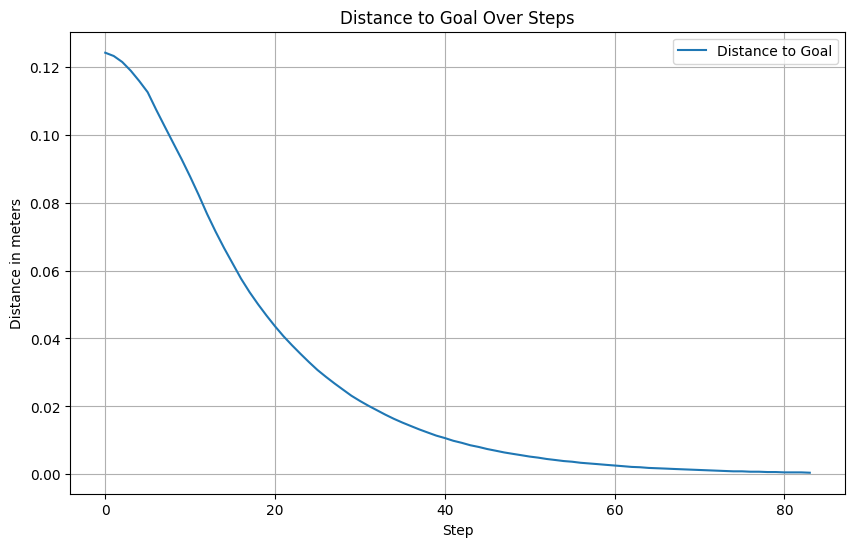



Plant 2:

Goal position is: (0.17087410841654777, 0.1373758915834522, 0.1695)
Inoculating point: (0.1712000072002411, 0.13689999282360077, 0.16949999332427979)

Inoculation successful with an error of:
0.0005767925509968779 meters in 55 steps or 0.51 seconds



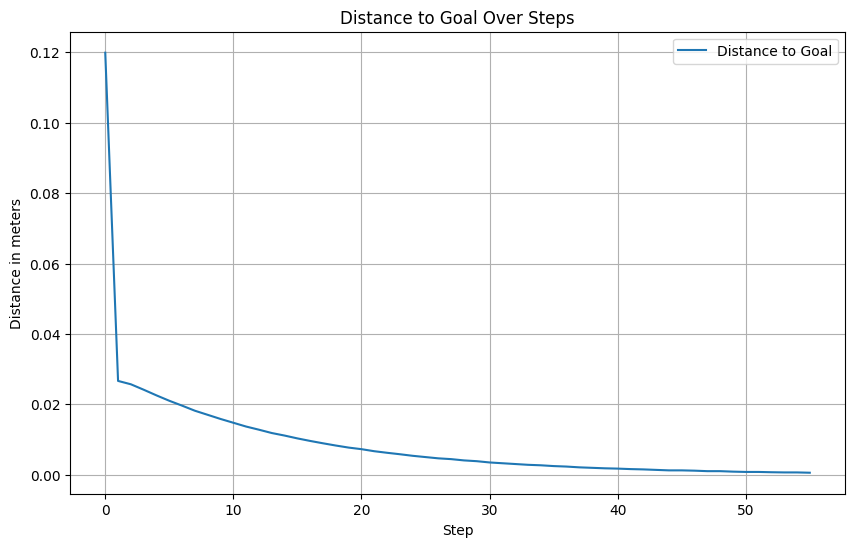



Plant 3:

Goal position is: (0.17044614835948646, 0.16439087018544934, 0.1695)
Inoculating point: (0.1704999953508377, 0.1639000028371811, 0.1695999950170517)

Inoculation successful with an error of:
0.0005038345517217481 meters in 57 steps or 0.53 seconds



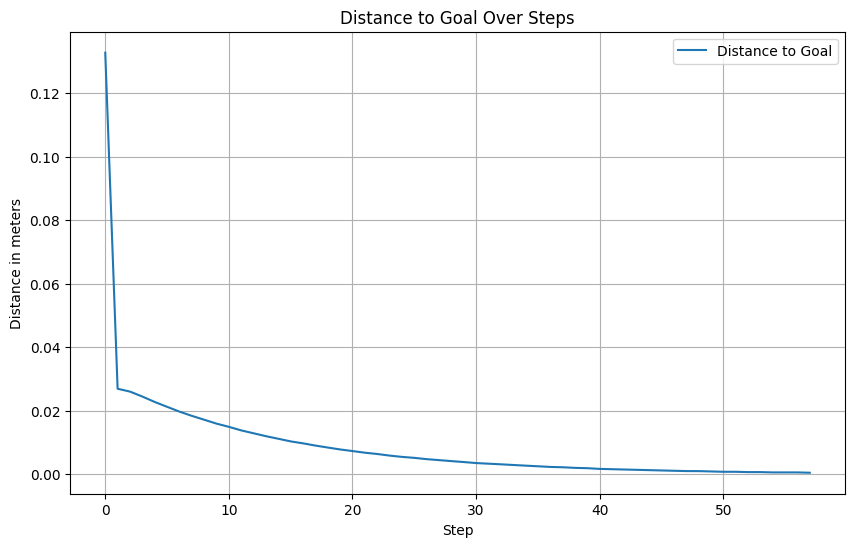



Plant 4:

Goal position is: (0.1690552781740371, 0.18990798858773178, 0.1695)
Inoculating point: (0.16910000145435333, 0.18950000405311584, 0.16949999332427979)

Inoculation successful with an error of:
0.00041042849844106973 meters in 58 steps or 0.61 seconds



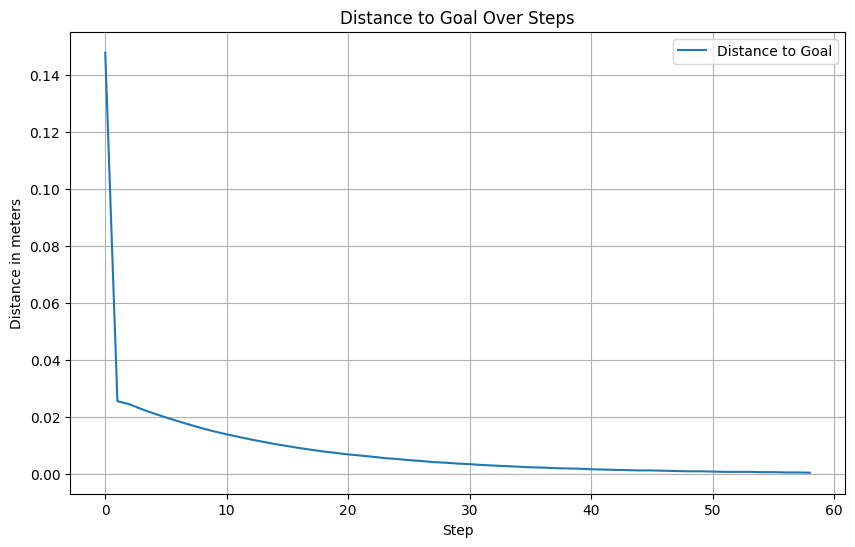



Plant 5:

Goal position is: (0.17173002853067046, 0.219972182596291, 0.1695)
Inoculating point: (0.17170000076293945, 0.21950000524520874, 0.1695999950170517)

Inoculation successful with an error of:
0.00048358258978703755 meters in 59 steps or 0.65 seconds



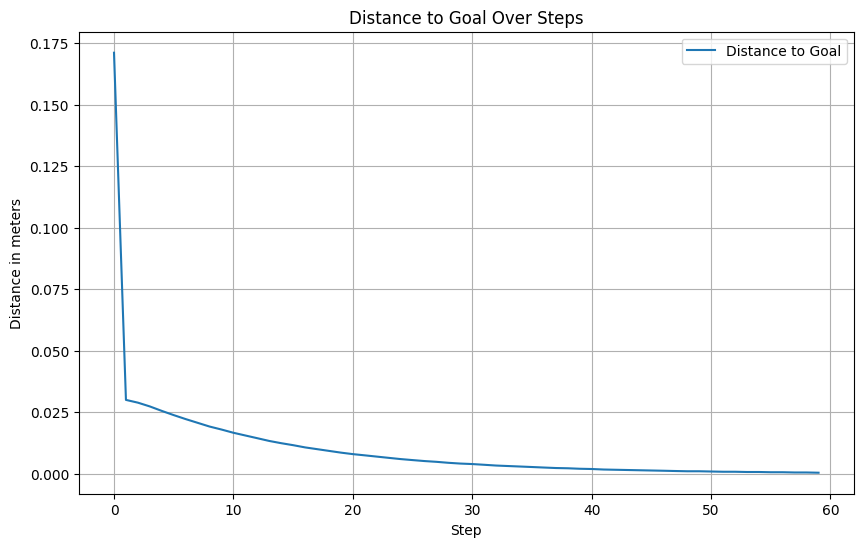

: 

In [13]:
# Loop through each goal position in the list
for idx, goal_pos in enumerate(goal_positions, 1):  # Start index at 1 for more natural numbering
        
    print(f'\n\nPlant {idx}:\n')
     
    goal_pos_y = offset_y + goal_pos[1]
    goal_pos_x = offset_x + goal_pos[0]
    
    # Call the function to run PID control for the current goal
    run_pid_to_goal(goal_pos_x, goal_pos_y, goal_pos_z, observation)
